<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 5 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 2 October 2019, with material from Philip Lewis, Department of Geography - University College London</div>

# Homework: Modeling Rainfall with the $\gamma$ distribution

Let's practice what we learned. Let's build a **Bayesian model** for a dataset, so we can extract precise statistics from the model itself, rather than the data. 

### How to build a Bayesian model?
* Look at the histogram of the data
* Pick an analytic probability densiy function matching the shape of the histogram
* Model its parameters (priors) as probability density functions
* Try different shape and values of these parameters (these are called *hyperparameters*)
* Run a probabilistic program to give us the posterior pdfs
* Plot the posterior means on top of the histogram and check if we get a good match!

Let's model rainfall data per calendar month for the city of Nashville, Tennessee. This is a classic problem in Bayesian estimation. Rainfall data is a great opportunity to introduce a new useful pdf to add to our portfolio: the $\gamma$ distribution. 

</br >
<center>
<img src="images/rainfall.jpeg" width=400 />
</center>



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import pymc3 as pm
sns.set_context('notebook')

RANDOM_SEED = 20090425

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\Users\admin\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1. The $\gamma$ distribution

This is the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution):

<div style="font-size: 120%;">  
$$\gamma(x) = \frac{\beta^\alpha x^{\alpha -1} e^{- \beta x}}{\Gamma (\alpha)}$$
</div>

</br >
<center>
<img src="images/ohnonotmath.png" width="300" />
</center>

How many parameters in the gamma function?

By the way, what is the $\Gamma()$ function? It [interpolates](https://en.wikipedia.org/wiki/Gamma_function) the factorial function to non-integer values!

This is what the $\gamma$ function for $x > 0$ and $\alpha, \beta > 0$ looks like:

</br >
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg" width="500" />
Gamma distribution
</center>

## 2. Dataset: Nashville Precipitation

The dataset `nashville_precip.txt` contains NOAA precipitation data for Nashville measured since 1871. Download it from blackboard and put it in the right folder (`C:/Users/<username>/data`). 
    
The $\gamma$ distribution happens to be a good fit to aggregated rainfall data, and will be our candidate model in this case. 

Let's peek at the data:

In [2]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


Let's do some data exploration..

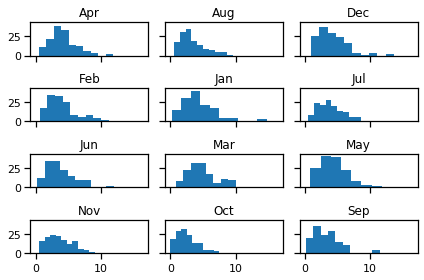

In [3]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

The first step is recognizing what sort of distribution to fit our data to. A couple of observations:

1. The data is *skewed*, with a longer tail to the right than to the left
2. The data is *positive-valued*, since they are measuring rainfall
3. The data is *continuous*

There are a few possible choices, but a good option is the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). If $x$ measures rainfall:

<div style="font-size: 120%;">  
$$x \sim \gamma(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$
</div>

The gamma distribution is often used to model the size of [insurance claims](https://www.crcpress.com/Statistical-and-Probabilistic-Methods-in-Actuarial-Science/Boland/p/book/9781584886952) and [rainfalls](http://journals.tubitak.gov.tr/engineering/issues/muh-00-24-6/muh-24-6-7-9909-13.pdf). This means that aggregate insurance claims and the amount of rainfall accumulated in a reservoir are usually well modelled by a gamma process.


## 3. Data Cleansing 

Wait a sec.. There's something wrong with our data.. if you open it in a text editor, you will find a value of NA for October of 1963 (take a look!). So we have to do some data cleansing first (remember the first step in data science from Lecture 1?). Given what we are trying to do, it is sensible to fill in the missing value with the **average of the available values** (another option would have been the average of the months of September and November 1963).


In [4]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30
1876,6.41,2.22,5.28,3.62,3.40,5.65,7.15,5.77,2.52,2.68,1.26,0.95
1877,4.05,1.06,4.98,9.47,1.25,6.02,3.25,4.16,5.40,2.61,4.93,2.49
1878,3.34,2.10,3.48,6.88,2.33,3.28,9.43,5.02,1.28,2.17,3.20,6.04
1879,6.32,3.13,3.81,2.88,2.88,2.50,8.47,4.62,5.18,2.90,5.85,9.15


## 4. Exploration

Let's calculate the **means** and **variances** of precipitation, month by month:

In [5]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [6]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

In [7]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
1876     3.62
1877     9.47
1878     6.88
1879     2.88
1880     5.26
1881     5.12
1882     3.59
1883     9.12
1884     3.51
1885     3.75
1886     2.36
1887     2.67
1888     4.18
1889     2.83
1890     3.84
1891     2.24
1892     7.45
1893     4.11
1894     4.05
1895     3.07
1896     2.92
1897     5.79
1898     3.16
1899     3.25
1900     4.04
        ...  
1982     4.36
1983     6.80
1984     8.41
1985     2.91
1986     0.52
1987     1.03
1988     2.09
1989     2.68
1990     1.60
1991     3.35
1992     0.77
1993     3.33
1994     5.72
1995     3.95
1996     3.68
1997     2.42
1998     6.31
1999     2.29
2000     6.23
2001     2.42
2002     4.31
2003     4.69
2004     6.69
2005     6.93
2006     4.14
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

Ok, now comes the most complicated part of Bayesian estimation: Let's pick pdfs for the $\gamma$ distribution's parameters $\alpha$ and $\beta$. We're taking numbers, and modeling them as distributions, so that we can take a probabilistic program to figure out the best values for these parameters. If you understand this, then you understand the most complicated part of Bayesian estimation theory!

Let's firt try to model rainfall for the month of April, only.


D:\Users\admin\Anaconda3\lib\site-packages\pandas\plotting\_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


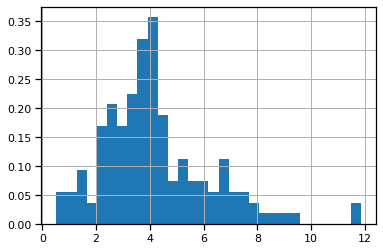

In [8]:
precip.Apr.hist(normed=True, bins=30)

### Exercise 1:

Start with the `Uniform` distribution. Rainfall for the month of April seems to go from 0 to 12 units, so let's pick the Uniform distribution to model the $\alpha$ parameter for our gamma function. The Uniform distribution also needs start and end parameters. We pick them to be wide enough to match the data. Then we model april rainfall with the Gamme distribution.

This is the modeling part:

```python
from pymc3 import Model, Uniform

with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)
    
with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)
```

This is the simulation part (the probabilistic program that yields the best values for parameters $\alpha$ and $\beta$). Be patient:
```python
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
```

And this is how we plot our posterior pdf for rainfall (our model for april):
```python
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');
```

Then we check if our posterior model matches our histogram. If it does, we say "we found a good model for April!"!

We can use the `gamma.pdf` function in `scipy.stats.distributions` to plot the distributions implied by the calculated alphas and betas. Yes, yes, I know, we have not introduced scipy official yet..

</br >
<center>
<img src="https://c402277.ssl.cf1.rackcdn.com/photos/14785/images/story_full_width/shutterstock_532108075.jpg" width=400 />
Lazy Professor!
</center>

```python
from scipy.stats.distributions import gamma

ualpha_posterior_mean = ...
ubeta_posterior_mean = ...

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))
```

In [9]:
from pymc3 import Model, Uniform

with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)

with rainfall_model:
    april_like = pm.Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

---
## Note--Gamma  in pymc3

[link](http://people.duke.edu/~ccc14/sta-663-2016/16c_pymc3.html)

## Note--Uniform in pymc3

[link](https://blog.csdn.net/qq_16000815/article/details/81481594)

---

In [10]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 366.68: 100%|██████████| 10000/10000 [00:51<00:00, 193.73it/s]
Finished [100%]: Average Loss = 366.52


D:\Users\admin\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


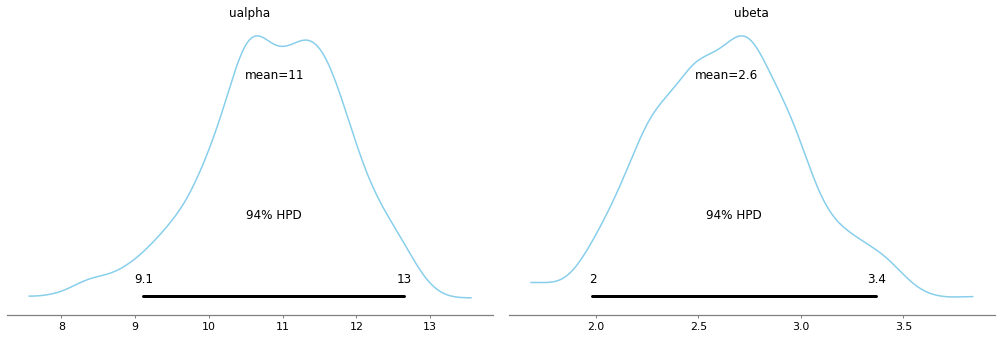

In [11]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');

D:\Users\admin\Anaconda3\lib\site-packages\pandas\plotting\_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


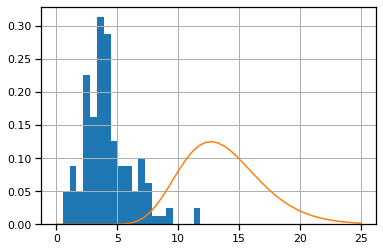

In [12]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 11
ubeta_posterior_mean = 2.7

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

Possible that some of my hyperparameters were not ideal. Hmm.. does anyone want to try different ones and improve on what professor's model using the Uniform distribution as a hyperparameter, for extra credit?

## How to optimize the model(For extra credit🤔)

First I check the distribution of Apirl rainfall

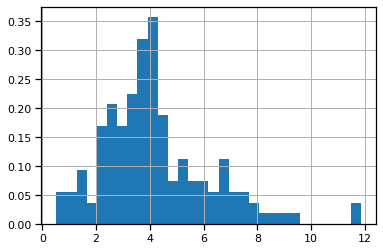

In [13]:
precip.Apr.hist(normed=True, bins=30)

Then I compare this distribution with gamma distribution

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg" width="300" />

So I find that gamma curve looks same with Apirl rainfall when α=9, β=0.5

Base on this, I reduce the range of ualpha and ubeta like (0,18) and (0,1)

In [14]:
from pymc3 import Model, Uniform

with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=18) # I change the range here
    ubeta = Uniform('ubeta', lower=0, upper=1) # I change the range here

with rainfall_model:
    april_like = pm.Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

In [15]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 301.85: 100%|██████████| 10000/10000 [00:49<00:00, 202.29it/s]
Finished [100%]: Average Loss = 301.82


D:\Users\admin\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


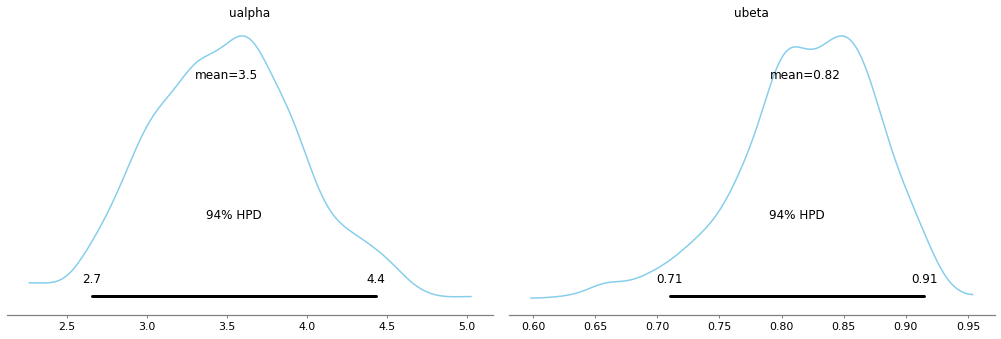

In [16]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');

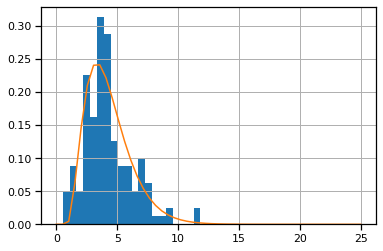

In [17]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 3.5
ubeta_posterior_mean = 0.82

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

The model looks better!🤔

### Exercise 2:

Did the Uniform distribution work out well in your modeling exercise above? Well, it didn't for professor!

Let's try the `Normal` distribution instead. Please make sure to introduce **new** variables for your priors (xxxalpha, xxxbeta), as well as your simulation trace (xxxapril_like). Replace xxx with whatever you want.

What's the right support for the normal (the right mean and standard deviation)? Pick a mean that centers the gaussian around the peak of the month, and a standard deviation that allows the gaussian to cover all the data.

### Normal distribution

First I want to plot the Apirl rainfalls distribution 

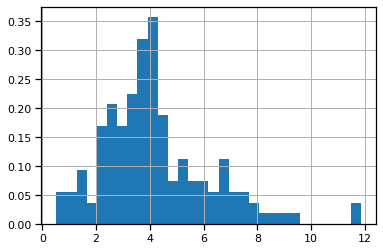

In [18]:
precip.Apr.hist(normed=True, bins=30)

In [19]:
from pymc3 import Model,Uniform, Normal

with Model() as rainfall_normal_model:
    nalpha = Normal('nalpha', 9, sd=10)
    nbeta = Normal('nbeta',4 ,sd = 10)
#     nbeta = Uniform('nbeta', lower = 0, upper = 1)

with rainfall_normal_model:
    normal_april_like = pm.Gamma('normal_april_like', alpha=nalpha, beta=nbeta, observed=precip.Apr)

D:\Users\admin\Anaconda3\lib\site-packages\pymc3\distributions\continuous.py:88: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
D:\Users\admin\Anaconda3\lib\site-packages\pymc3\distributions\continuous.py:88: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [20]:
from pymc3 import fit

with rainfall_normal_model: 
    rainfall_normal_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 336.89: 100%|██████████| 10000/10000 [00:47<00:00, 210.12it/s]
Finished [100%]: Average Loss = 336.85


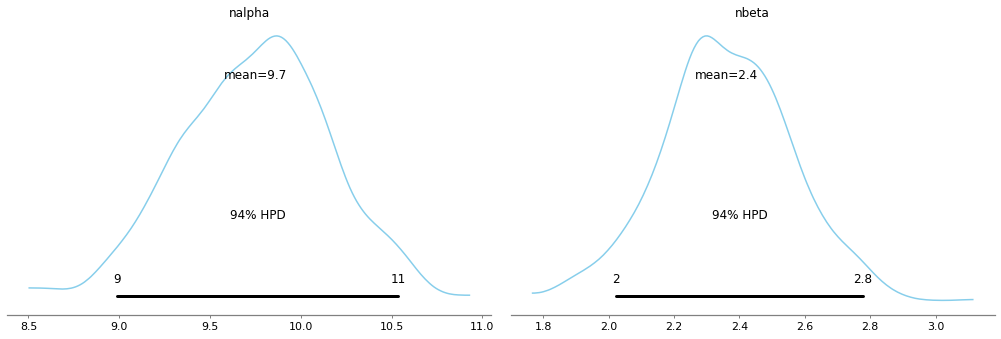

In [21]:
from pymc3 import plot_posterior

plot_posterior(rainfall_normal_trace[100:], 
                varnames=['nalpha', 'nbeta'],
                color='#87ceeb');

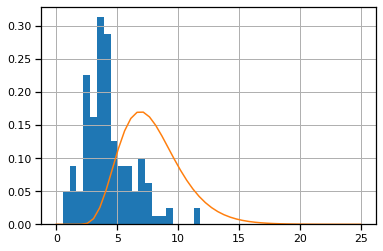

In [22]:
from scipy.stats.distributions import gamma

nalpha_posterior_mean = 6.3
nbeta_posterior_mean = 1.6

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), nalpha_posterior_mean, nbeta_posterior_mean))

### Exercise 3: 

Let's try to accelerate things and try the exponential distribution, instead. Find the right number $x$ so that the distribution covers the range of possible precipitation values.  In other words, find the right value $y$ such that `Exponential.dist(1/3).random(size=10000)` covers from 0 to 12 for the month of April. Try different values out by plotting with:

```python
sns.distplot(Exponential.dist(1/3).random(size=10000), kde=False);
```


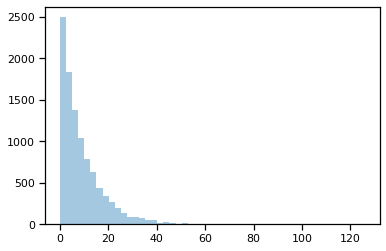

In [25]:
from pymc3 import Model,Uniform, Exponential
sns.distplot(Exponential.dist(1/9).random(size=10000), kde=False);

In [26]:


with Model() as rainfall_exponential_model:
    ealpha = Exponential('ealpha',1/5 )
    ebeta = Exponential('ebeta', 1/3)

with rainfall_exponential_model:
    exponential_april_like = pm.Gamma('exponential_april_like', alpha=ealpha, beta=ebeta, observed=precip.Apr)

In [27]:
from pymc3 import fit

with rainfall_exponential_model: 
    rainfall_exponential_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 316.61: 100%|██████████| 10000/10000 [00:48<00:00, 204.54it/s]
Finished [100%]: Average Loss = 316.47


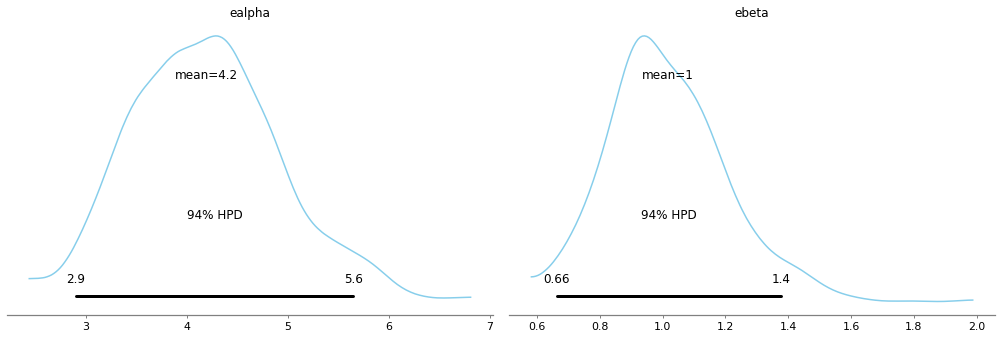

In [28]:
from pymc3 import plot_posterior

plot_posterior(rainfall_exponential_trace[100:], 
                varnames=['ealpha', 'ebeta'],
                color='#87ceeb');

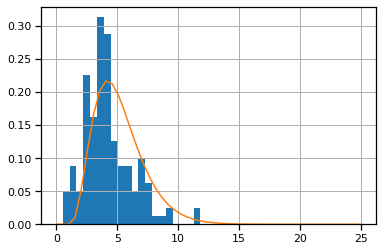

In [29]:
from scipy.stats.distributions import gamma

ealpha_posterior_mean = 4.2
ebeta_posterior_mean = 1

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ealpha_posterior_mean, ebeta_posterior_mean))

### Exercise 4:

Do the month of January.

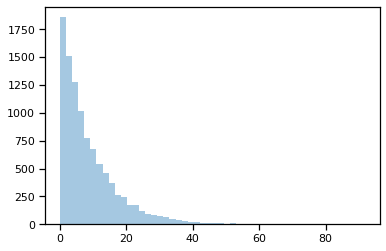

In [30]:
sns.distplot(Exponential.dist(1/9).random(size=10000), kde=False);

In [31]:
from pymc3 import Model,Uniform, Exponential

with Model() as rainfall_exponential_jan_model:
    ealpha = Exponential('ealpha',1/precip.Jan.mean() )
    ebeta = Exponential('ebeta', 1/3)

with rainfall_exponential_jan_model:
    exponential_april_like = pm.Gamma('exponential_april_like', alpha=ealpha, beta=ebeta, observed=precip.Apr)

In [32]:
from pymc3 import fit

with rainfall_exponential_jan_model: 
    rainfall_exponential_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 316.74: 100%|██████████| 10000/10000 [00:48<00:00, 204.63it/s]
Finished [100%]: Average Loss = 316.61


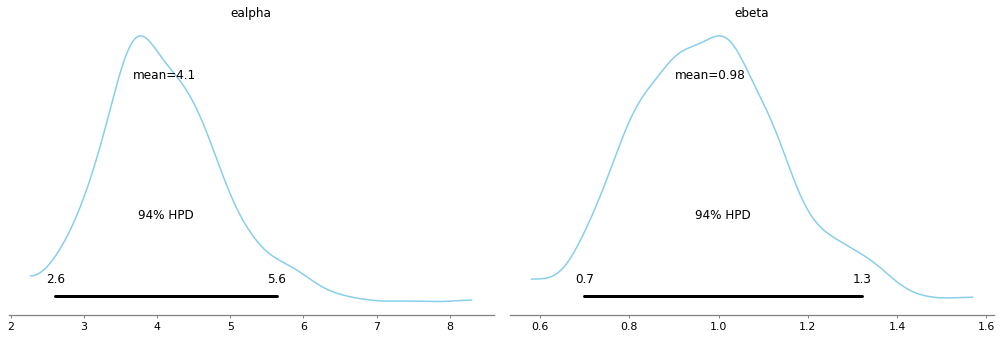

In [33]:
from pymc3 import plot_posterior

plot_posterior(rainfall_exponential_trace[100:], 
                varnames=['ealpha', 'ebeta'],
                color='#87ceeb');

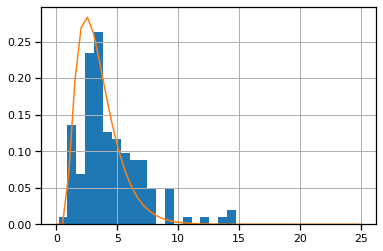

In [34]:
from scipy.stats.distributions import gamma

ealpha_posterior_mean = 2.8
ebeta_posterior_mean = 0.65

precip.Jan.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ealpha_posterior_mean, ebeta_posterior_mean))

### (Deep thought) Exercise 5:

How would you model *all* months together (*one* model, *all* months)? Is that even possible?

Merge all months data into one column.

In [38]:
precip_all=pd.concat(precip.iloc[:,i] for i in range(precip.shape[1]))
precip_all.head(10),len(precip_all)

(Year
 1871    2.76
 1872    2.32
 1873    2.96
 1874    5.22
 1875    6.15
 1876    6.41
 1877    4.05
 1878    3.34
 1879    6.32
 1880    3.74
 dtype: float64, 1692)

Use all month dataset to train gamma module

In [40]:
from pymc3 import Model,Uniform, Exponential

with Model() as rainfall_exponential_jan_model:
    ealpha = Exponential('ealpha',1/precip.Jan.mean() )
    ebeta = Exponential('ebeta', 1/3)

with rainfall_exponential_jan_model:
    exponential_april_like = pm.Gamma('exponential_april_like', alpha=ealpha, beta=ebeta, observed=precip_all)

This will take about 5 min.

In [41]:
from pymc3 import fit

with rainfall_exponential_jan_model: 
    rainfall_exponential_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 3,863.8: 100%|██████████| 10000/10000 [06:59<00:00, 23.85it/s]
Finished [100%]: Average Loss = 3,862.4


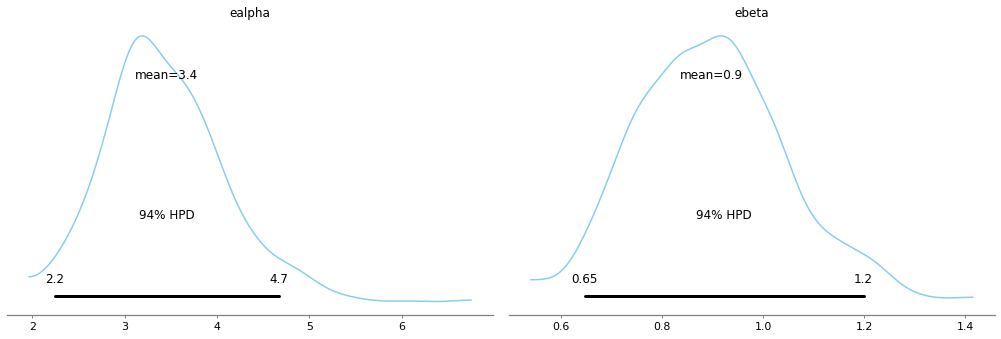

In [42]:
from pymc3 import plot_posterior

plot_posterior(rainfall_exponential_trace[100:], 
                varnames=['ealpha', 'ebeta'],
                color='#87ceeb');

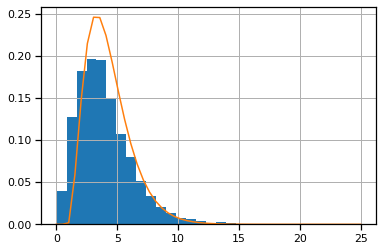

In [45]:
from scipy.stats.distributions import gamma

ealpha_posterior_mean = 3.4
ebeta_posterior_mean = 0.9

precip_all.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ealpha_posterior_mean, ebeta_posterior_mean))

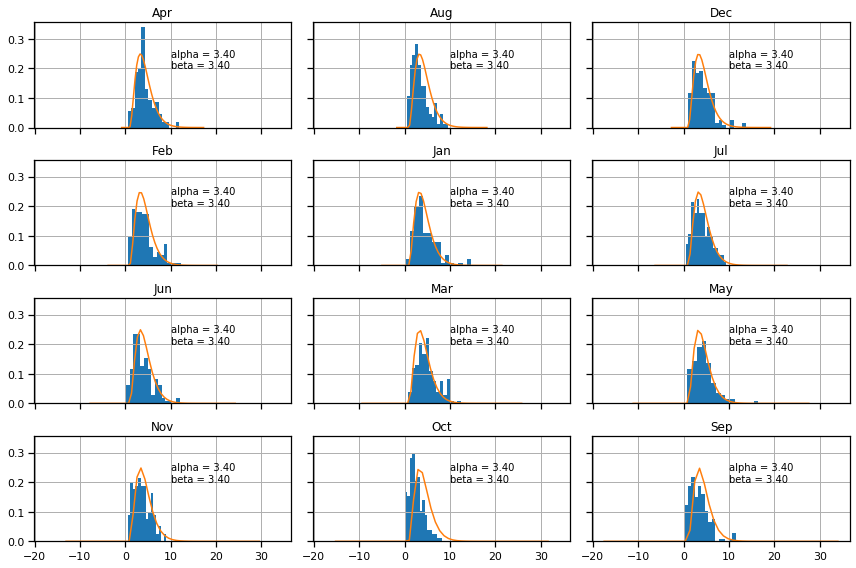

In [46]:
axs = precip.hist(normed=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

for ax in axs.ravel():

    # Get month
    m = ax.get_title()

    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, ealpha_posterior_mean, ebeta_posterior_mean))

    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(ealpha_posterior_mean, ealpha_posterior_mean)
    ax.annotate(label, xy=(10, 0.2))

plt.tight_layout()